# Demo of Biologically Plausible Image Augmentations 
Foveation blur, cortical magnification and saccade model.

In [34]:
%load_ext autoreload 
%autoreload 2
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from PIL import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
!git clone https://github.com/Animadversio/Foveated_Saccade_SimCLR.git
%cd Foveated_Saccade_SimCLR

Cloning into 'Foveated_Saccade_SimCLR'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 152 (delta 0), reused 2 (delta 0), pack-reused 147
Receiving objects: 100% (152/152), 1.55 MiB | 11.86 MiB/s, done.
Resolving deltas: 100% (64/64), done.
/content/Foveated_Saccade_SimCLR/Foveated_Saccade_SimCLR


In [36]:
!pip install kornia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
!git checkout dev

Branch 'dev' set up to track remote branch 'dev' from 'origin'.
Switched to a new branch 'dev'


In [38]:
import numpy as np
from os.path import join
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage, ToTensor
from torch.nn.functional import interpolate
from data_aug.aug_utils import send_to_clipboard
from data_aug.foveation import FoveateAt, randomFoveated, FoveateAt_demo

In [39]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Foveation Transform Demo

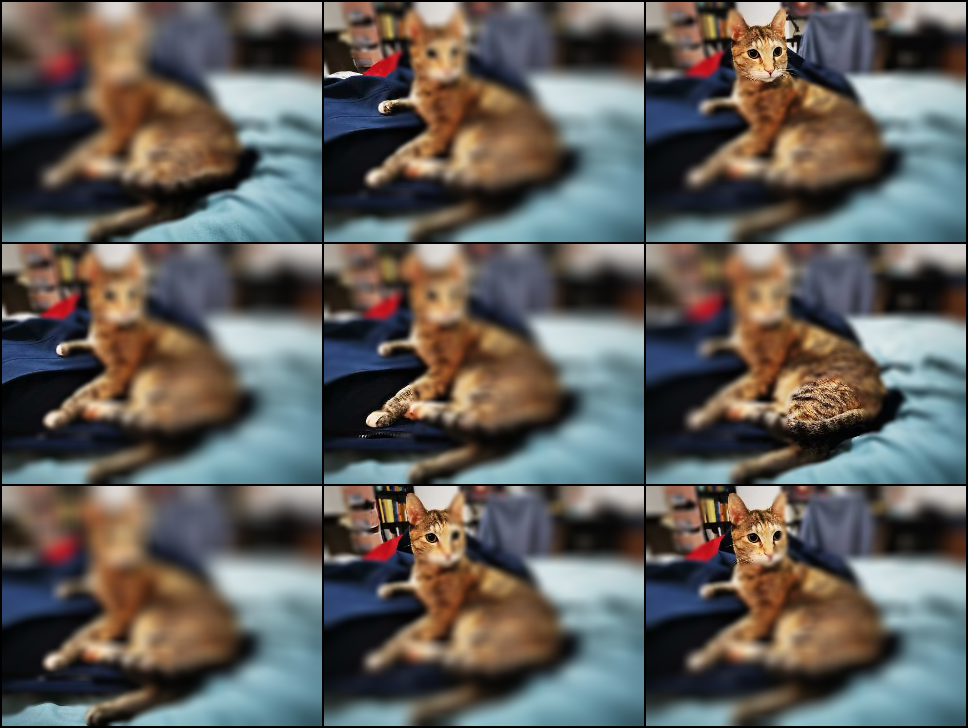

In [40]:
img = plt.imread("media/Gigi_resize.jpg")
img_tsr = torch.tensor(img / 255.0).permute([2, 0, 1]).unsqueeze(0).float()
img_tsr_rsz = interpolate(img_tsr, scale_factor=0.5) # resized to 240x320 pix
views = randomFoveated(img_tsr_rsz, pntN=9, bdr=16, kerW_coef=0.04, spacing=0.2, fov_area_rng=0.05)
ToPILImage()(make_grid(views.squeeze(1), nrow=3))

In [41]:
# @title Effect of Foveation Blur parameters (e_o, kerW_coef, spacing)
@interact(fixX = widgets.IntSlider(min=0, max=320, step=1, value=110),
    fixY = widgets.IntSlider(min=0, max=240, step=1, value=50),
    e_o = widgets.FloatSlider(min=0.1, max=10, step=0.1, value=1.0),
    kerW_coef = widgets.FloatLogSlider(min=-2, max=0, base=10, value=0.04),
    spacing = widgets.FloatSlider(min=0.1, max=2, step=0.1, value=0.5))
def foveation_demo(fixX=50, fixY=100, e_o=1.0, kerW_coef=0.04, spacing=0.5):
  fov_imgtsr = FoveateAt(img_tsr_rsz, pnt=(fixY, fixX), kerW_coef=kerW_coef, e_o=e_o, 
      N_e=None, spacing=spacing, )
  display(ToPILImage()(fov_imgtsr[0]))

interactive(children=(IntSlider(value=110, description='fixX', max=320), IntSlider(value=50, description='fixY…

If you are interested in how this transform is implemented, you can look at this demo. 

In [42]:
# @title Implementation of Spatial Adaptive Blur
finalimg, mask_col, blurimg_col, multiply_col = FoveateAt_demo(img_tsr_rsz, (50, 120), 
                kerW_coef=0.04, spacing=0.4, e_o=0.6,)

@interact(ring_num=widgets.IntSlider(min=0, max=len(mask_col),))
def show_result(ring_num):
  i=ring_num
  print("%dth ring mask of blur"%i)
  display(Image.fromarray(np.uint8(mask_col[i]*255)))
  print("%dth blurred image"%i)
  display(ToPILImage()(blurimg_col[i]))
  print("%dth blurred image * mask"%i)
  display(ToPILImage()(multiply_col[i]))

interactive(children=(IntSlider(value=0, description='ring_num', max=10), Output()), _dom_classes=('widget-int…

## Cortical Magnification Transform

In [43]:
from data_aug.cort_magnif_tfm import cortical_magnif_tsr_demo, img_cortical_magnif_tsr, \
                                     radial_exp_isotrop_gridfun, radial_quad_isotrop_gridfun

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4216: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


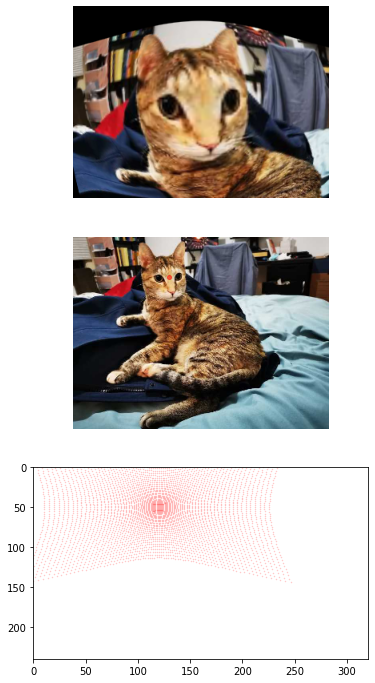

In [44]:
fighm, img_cm, img = cortical_magnif_tsr_demo(img_tsr_rsz, (50, 120),
      lambda img, pnt: radial_quad_isotrop_gridfun(img, pnt, fov=20, K=20, cover_ratio=0.35), subN=4)

### Intuitions of Cortical Magnification

* `fixX` and `fixY` control fixation point. 
* `fov` control the radius of linear sampling (non-distortion area)
* `K` control the quadratic function i.e. the degree of distortion in periphery
* `cover_ratio` control area of sampling relative to the full image size. It's approximately the ratio of image area under sampling grid and full image size. 

In [45]:
# @title Effects of Cortical Magnification Parameters (fov, K, cover_ratio)
@interact(fixX = widgets.IntSlider(min=0, max=320, step=1, value=110),
    fixY = widgets.IntSlider(min=0, max=240, step=1, value=50),
    fov = widgets.IntSlider(min=0, max=100, step=1, value=51),
    K = widgets.FloatSlider(min=-30, max=35, step=0.5, value=-14.5),
    cover_ratio = widgets.FloatSlider(min=0.01, max=2, step=0.01, value=0.22))
def demofunc(fixX, fixY, fov, K, cover_ratio):
  fighm, img_cm, img = cortical_magnif_tsr_demo(img_tsr_rsz, (fixY, fixX),
    lambda img, pnt: radial_quad_isotrop_gridfun(img, pnt, fov=fov, K=K, cover_ratio=cover_ratio))

interactive(children=(IntSlider(value=110, description='fixX', max=320), IntSlider(value=50, description='fixY…

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4216: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


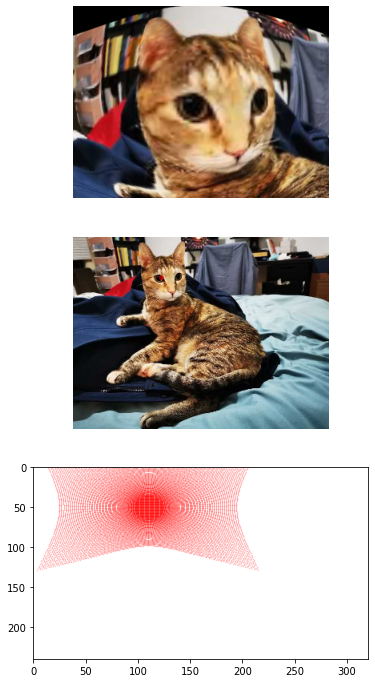

In [46]:
fixX = 110 #@param {type:"slider", min:0, max:320, step:1}
fixY = 50 #@param {type:"slider", min:0, max:240, step:1}
fov = 51 #@param {type:"slider", min:0, max:100, step:1}
K = -14.5 #@param {type:"slider", min:-30, max:35, step:0.5}
cover_ratio = 0.22 #@param {type:"slider", min:0.01, max:2, step:0.01}
fighm, img_cm, img = cortical_magnif_tsr_demo(img_tsr_rsz, (fixY, fixX),
    lambda img, pnt: radial_quad_isotrop_gridfun(img, pnt, fov=fov, K=K, cover_ratio=cover_ratio))

In [47]:
# @title Visualization of Radial Function
@interact(fov = widgets.IntSlider(min=0, max=50, step=1, value=15),
    K = widgets.FloatSlider(min=-20, max=35, step=0.5, value=-7.5),
    cover_ratio = widgets.FloatSlider(min=0.01, max=2, step=0.01, value=0.22))
def demofunc(fov, K, cover_ratio):
  xarr = np.arange(0,100,0.1)
  RadDistTfm = lambda R: (R < fov) * R + \
        (R >= fov) * ((R + K) ** 2 / 2 / (fov + K) + fov - (fov + K) / 2)
  ecc_raw = RadDistTfm(xarr)
  coef = 100 / ecc_raw.max()
  plt.plot(xarr, coef*ecc_raw*np.sqrt(cover_ratio))
  plt.xlabel("cortical distance")
  plt.ylabel("retinal degree")
  plt.show()

interactive(children=(IntSlider(value=15, description='fov', max=50), FloatSlider(value=-7.5, description='K',…

In [48]:
# @title Visualization of Radial Function
@interact(fov = widgets.IntSlider(min=0, max=50, step=1, value=30),
    K = widgets.FloatSlider(min=-50, max=35, step=0.5, value=-15),
    cover_ratio = widgets.FloatSlider(min=0.01, max=2, step=0.01, value=0.22))
def demofunc(fov, K, cover_ratio):
  xarr = np.arange(0,100,0.1)
  RadDistTfm = lambda R: (R < fov) * R + \
        (R >= fov) * ((R + K) ** 2 / 2 / (fov + K) + fov - (fov + K) / 2)
  ecc_raw = RadDistTfm(xarr)
  coef = 100 / ecc_raw.max()
  plt.plot(xarr, coef*ecc_raw*np.sqrt(cover_ratio))
  plt.xlabel("cortical distance")
  plt.ylabel("retinal degree")
  plt.show()

interactive(children=(IntSlider(value=30, description='fov', max=50), FloatSlider(value=-15.0, description='K'…

## Saliency Based Sampling

In [49]:
%cd /content/
!git clone https://github.com/Animadversio/FastSal

/content
fatal: destination path 'FastSal' already exists and is not an empty directory.


In [50]:
%cd /content/Foveated_Saccade_SimCLR/

/content/Foveated_Saccade_SimCLR


In [51]:
%mv /content/FastSal/utils.py /content/FastSal/utils_fastsal.py 
# rename utils.py in fastsal to avoid calling utils.py in Foveated_Saccade_SimCLR

mv: cannot stat '/content/FastSal/utils.py': No such file or directory


In [ ]:
# Prepare the FastSal CNN model
import sys
sys.path.append("/content/FastSal")
import model.fastSal as fastsal
from utils_fastsal import load_weight

In [54]:
# to make the next line work, revise /content/FastSal/model/adaptation_layer.py
# Line 43 misc_nn_ops.Conv2d -> nn.Conv2d
# Line 77 super(adaptation_layers, self).__init__() -> super(adaptation_layers, self).__init__()

model = fastsal.fastsal(pretrain_mode=False, model_type='A')
state_dict, opt_state = load_weight("/content/FastSal/weights/salicon_A.pth", remove_decoder=False)
model.load_state_dict(state_dict)
model.to(DEVICE).eval();

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [55]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from os.path import join
import matplotlib.pylab as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from data_aug.aug_utils import unravel_indices

In [56]:
img = plt.imread("/content/Foveated_Saccade_SimCLR/media/Gigi_resize.jpg")
imgtsr = torch.tensor(img/255.0).float().permute([2,0,1]).unsqueeze(0)
with torch.no_grad():
  salmap = model(imgtsr.to(DEVICE))
salmap_np = salmap.cpu()[0,0,:,:]

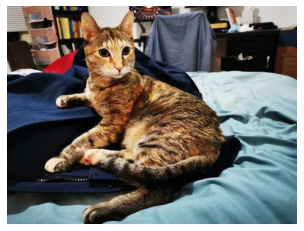

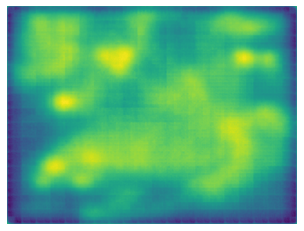

In [57]:
plt.imshow(img)
plt.axis("off")
plt.show()
plt.imshow(salmap_np)
plt.axis("off");
plt.show()

In [58]:
# @title Effect of Saccade Parameters (Temperature, border width)
_, _, H, W = imgtsr.shape
logdensity = salmap
@interact(sample_temperature=widgets.FloatLogSlider(min=-2, max=2, value=1.0, base=10),
     bdr=widgets.IntSlider(min=0, max=64, value=16),
     Npnt=fixed(200))
def salsampling(sal_sample=True, sample_temperature=1.0, bdr=16, Npnt=100,):
  if sal_sample:
    # print("sample with saliency")
    density = torch.exp((logdensity - logdensity.max()) / sample_temperature)
    # set the border density to be 0,
    density_mat = torch.zeros_like(density[0, 0, :, :])
    density_mat[bdr:H - bdr, bdr: W - bdr] = density[0, 0, bdr:H - bdr, bdr: W - bdr]
    # sample from density
    flat_idx = torch.multinomial(density_mat.flatten(), Npnt, replacement=True).cpu()
    cnt_coord = unravel_indices(flat_idx, density_mat.shape)
    pY, pX = cnt_coord[:, 0], cnt_coord[:, 1]
  else:
    pY = np.random.randint(bdr, H - bdr, size=Npnt)
    pX = np.random.randint(bdr, W - bdr, size=Npnt)
  print("Fixation point distribution (N=%d)"%Npnt)
  plt.figure()
  plt.imshow(logdensity[0,0,:,:])
  plt.scatter(pX, pY, c="r", alpha=0.5)
  plt.axis("off")
  plt.show()
  return

interactive(children=(Checkbox(value=True, description='sal_sample'), FloatLogSlider(value=1.0, description='s…